In [ ]:
color_scatter = 'C0'  # 'C0' for default color #0
color_line = 'C1'     # 'C1' for default color #1
color_shade = (
    1 - 0.1*(1 - np.array(mpl.colors.to_rgb(color_line)))
)
for model in [sep_models_samples[0]]:
    for samples in [model[21]]:
        

        expmu = np.exp(samples['mu'])*100
        
        plt.fill_between(
            range(2001,2011),
            np.percentile(expmu, 5, axis=0),
            np.percentile(expmu, 95, axis=0),
            color=color_shade
        )

        plt.plot(
            range(2001,2011),
            np.percentile(expmu, 50, axis=0),
            color=color_line,
            linewidth=1
        )

        plt.scatter(range(2001,2011), data[21]*100) #5, color=color_scatter)
        plt.xlim((2001, 2010))
        
        #ax.tight_layout()
    plt.show()

## Introduction
In this project we will go through a complete Bayesian data analysis of historical data about deaths for viral hepatitis in different countries of Europe. The points that we want to develop are the following:
 - description of the analysis problem
 - description of the models that will be used in the analysis
 - description of how these models are translated into stan code and how they are run
 - fitting of the differnt models and analysis of results and performance
 - comparison among the different models
 - analysis of the quality of the prediction for a new (unseen by the model) year
 - conclusions and final remarks
The main goal is to use historical data in order to fit a model capable of making predictions on the following years. You can see and example in the figure below:

![Separate Model](./separate.png)


 
## Analysis problem
The dataset that we want to analyze in this project is about number of deaths for viral hepatitis and sequelae of viral hepatitis in 25 European countries over 10 years, from 2001 to 2010. Our dataset is divided into two files:
 - one contains the total amount of deaths for all causes of death
 - the other contains the number of deaths for viral hepatitis and sequelae of viral hepatitis

The data in the first file will be used as normalization factor for the number of deaths for viral hepatitis. Therefore, the data that will be analyzed is the ratio of deaths for viral hepatitis over the total number of deaths in that country.
Our objective for this analysis is to predict for each country the number of deaths for viral hepatitis in the following years. We decided not to make any prediction for a country outside the list because, even if there could be a hyperdistribution which the parameters of our models could follow, we considered that there could be too many differences among the countries which would make such a prediction unreliable.

## Model description
As first choice we will assess the use of a Separate model. We will consider each country as a separate group, and so we will have a distribution that describe each of them independently. 

![Separate Model](./separate.png)

We will also evaluate a Hierarchial model, in order to verify that our initial assumption about the independece of the distribution of each country is correct. In other words, we expect that the hierarchial model will perform worse than the Separate model, which is our first choice.

![Hierarchial Model](./hierarchial.png)

## Prior choices
Our prior hypothesis is that we assume that the data for each  distributed $y_{ij}\mid\theta_j \sim \mathcal{N}(\mu_ {ij}, \sigma_j)$.


### Separate
In the Separate models we will fit a linear gaussian model for each group independently:
$$\mu_{ij} = \alpha_j + \beta_j x_{ij}$$

The choices of the priors for each separate model are the following:
 - uniform priors on $\alpha$, $\beta$, $\sigma$
 - gaussian and uniform priors: $\alpha \sim \mathcal{N}(\mathbb{E}(y), 100)$, $\beta \sim \mathcal{N}(0, 1)$, Uniform on $\sigma$ 
 - gaussian, student t, uniform priors: $\alpha \sim \mathcal{N}(\mathbb{E}(y), 100)$, $\beta \sim \mathcal{t}(3, 0, 10)$, Uniform on $\sigma$

### Hierarchical
In the Hierarchial model we will add the layer represented by the hyperdistributions for $\alpha$, $\beta$ and $\sigma$ as displayed below:
$$\alpha \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha)$$
$$\beta \sim \mathcal{N}(\mu_\beta, \sigma_\beta)$$
$$\sigma \sim Inv-\chi^2(\sigma_0, \nu_0)$$

 - uniform hyperprior parameters for $\mu_{\alpha}$, $\mu_{\beta}$, $\sigma_{\alpha}$, $\sigma_{\beta}$, $\sigma_{0}$, $\nu_0$
 - weakly informative hyperprior parameters: 
     $$\mu_{\alpha} \sim \mathcal{N}(0, 10)$$
     $$\mu_{\beta} \sim \mathcal{N}(0, 10)$$
     $$\sigma_{\alpha} \sim Cauchy(0, 1)$$
     $$\sigma_{\beta} \sim Cauchy(0, 10)$$
     $$\sigma_{0} \sim Cauchy(0, 1)$$
     $$\nu_0 \sim Gamma(2, 0.1)$$
   we used $Cauchy(0, 10)$ for $\sigma_{\beta}$ because we wanted to give less prior knowledge about the angular coefficient for the linear model


In [31]:
import pystan
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import stan_utility
import matplotlib as mpl
import psis
from sklearn.metrics import mean_squared_error

d = pd.read_csv("../dataset/deads.txt", sep=" ", header=None, skiprows=1)
h = pd.read_csv("../dataset/hepatitis.txt", sep=" ", header=None, skiprows=1)
countries = d[0].as_matrix()
d = d.iloc[:, 1:d.shape[1]].as_matrix()
h = h.iloc[:, 1:h.shape[1]].as_matrix()

data = h/d


### Data visualization
The following is a plot of the original data for each country

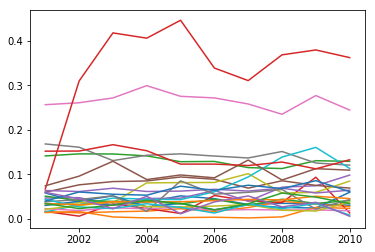

In [2]:
for i in range(25):
    plt.plot(range(2001, 2011), data[i]*100)
plt.show()

# Separate models
We are now going to fit every separate model with all the data provided.
In order to keep this notebook more clear the Stan code for the different models can be found in **Appendix A** for all the separated models.

In [3]:
sep_models = ["separ_non_unif_prior.stan", "separ_unif_prior.stan", "separ_non_unif_prior_stud.stan"]
sep_stan_models = []
for model in sep_models:
    separate_model_code = open("./models/"+model, "r").read()

    sep_stan_models.append(stan_utility.compile_model_plus(separate_model_code))

Using cached StanModel
Using cached StanModel
Using cached StanModel


In [30]:
N = 10
x = range(2001, 2011)
xpred=2011
K = 25
sep_models_samples = []
for sm in sep_stan_models:
    samples = []
    for i in range(K):
        y = np.log(data[i]).ravel()   # observations
        separate_model_data = dict(
            N = N,
            #K = K,  # 25 contries
            x = x,  # group indicators
            y = y,  # observations
            ymean = y.mean(),
            xpred=xpred
        )

        samples.append(sm.sampling(n_jobs=4, data=separate_model_data))#, control=dict(adapt_delta=0.95, max_treedepth=20)))

        #print('Completed: group ', i)
    print('Completed: separate model')
    sep_models_samples.append(samples)

Completed: separate model
Completed: separate model
Completed: separate model


# Hierarchical models
We are now going to fit every hierarchical model with all the data provided. In order to keep this notebook more clear the Stan code for the different models can be found in **Appendix B** for all the separated models.

In [5]:
hier_models = ["hier_unif_hyperprior.stan", "hier_non_unif_hyperprior.stan"]
hier_stan_models = []
for model in hier_models:
    model_code = open("./models/"+model, "r").read()
    hier_stan_models.append(stan_utility.compile_model_plus(model_code))
    #hier_stan_models.append(pystan.StanModel(model_code=model_code))

Using cached StanModel
Using cached StanModel


In [6]:
K=25
nj = 10
N = nj*K
x = np.array([i for i in range(1,K+1) for j in range(10)])
# print(x)
y = np.log(data[0:K]).ravel()  # observations
xpred=K+1

hier_models_samples = []

for sm in hier_stan_models:
    hierarchical_model_data = dict(
        N = N,
        K = K,  # 25 contries
        x = x,  # group indicators
        y = y,  # observations
        xpred=xpred
    )

    hier_models_samples.append(sm.sampling(n_jobs=-1, data=hierarchical_model_data))

print('Completed - hierarchical model')

Completed - hierarchical model


## How Stan models are run

In order to assess the performance of the models and compare them we are going to fit all the different models on the whole dataset, only later on we will fit these models on the first 9 years of data so that we can make prediction for the 10th year and use the actual data points as ground truth to estimate the prediction errors.

### Separate models
Given that we are using different separate models, we created a Stan model for each separate model which is run once on the data of each country. 

### Hierarchical models
In the hierarchical model we created a single Stan model for each of the proposed hierarchical models to analyse the whole dataset at once.

## Convergence analysis
### Separate model
The follwing code is writing the convergence analysis on different files in orther to keep this notebook more clean. The full tables can be found in **Appendix C**.

In [ ]:
sep_fit = open("sep_model_samples.txt", "w")
sep_divergences = open("sep_model_divergences.txt", "w")
sep_depthtree = open("sep_model_depthtree.txt", "w")
for group in sep_models_samples:
    sep_fit.write("\n\n---------------------------------------------------\n\n")
    sep_divergences.write("\n\n---------------------------------------------------\n\n")
    sep_depthtree.write("\n\n---------------------------------------------------\n\n")
    
    for samples in group:
        sep_fit.write(str(samples))
        sep_divergences.write(str(stan_utility.check_div(samples)))
        sep_depthtree.write(str(stan_utility.check_treedepth(samples)))
sep_fit.close()
sep_divergences.close()
sep_depthtree.close()

#### R-hat
For every separated model separately we have that each value of $\widehat{R}$ is very close to 1.0 and in any case under 1.1, therefore we can say that each model has converged.

#### Divergences
We accessed the level of divergences in the model. This level was non zero but running the model again with a higher acceptance probability made them disappear, so they were likely to be false positives.

#### Tree Depth
The tree depth was checked on these models to check if Stan had saturated the threshold for the maximum trajectory lenght. With the default value of `max_treedepth` we could experience a high amount of saturation. Setting a deeper value for the trees made the saturation get much lower, suggesting that the previous reports for saturation were likely to be false positives due to too short trees.

### Hierarchical Model
The follwing code is writing the convergence analysis on different files in orther to keep this notebook more clean. The full tables can be found in **Appendix D**.

In [ ]:
hier_fit = open("hier_model_samples.txt", "w")
hier_divergences = open("hier_model_divergences.txt", "w")
hier_depthtree = open("hier_model_depthtree.txt", "w")
for samples in hier_models_samples:
    hier_fit.write("\n\n---------------------------------------------------\n\n")
    hier_divergences.write("\n\n---------------------------------------------------\n\n")
    hier_depthtree.write("\n\n---------------------------------------------------\n\n")
    hier_fit.write(str(samples))
    hier_divergences.write(str(stan_utility.check_div(samples)))
    hier_depthtree.write(str(stan_utility.check_treedepth(samples)))
hier_fit.close()
hier_divergences.close()
hier_depthtree.close()

#### R-hat
For the different hierarchical models we have that each value for $\widehat{R}$ is very close to 1.0 and in any case under 1.10 . Therefors, we can say that the model is converging.

#### Divergences
We accessed the level of divergences in the model. This level was non zero but running the model again with a higher acceptance probability made them disappear, so they were likely to be false positives.

#### Tree Depth
The tree depth was checked on these models to check if Stan had saturated the threshold for the maximum trajectory lenght. With the default value of `max_treedepth` we could experience a high amount of saturation. Setting a deeper value for the trees made the saturation get much lower, suggesting that the previous reports for saturation were likely to be false positives due to too short trees.

## Posterior predictive checking

### Separate Models
In order to check how well the different models are fitting the data, we will use leave-one-out (LOO) cross validation method. In particular, we will use PSIS-LOO (Pareto smoothed importance sampling LOO) code for computing approximate LOO-CV. 

Effective number of parameteres:  53.7994626963
PSIS-LOO:  -31.788004285


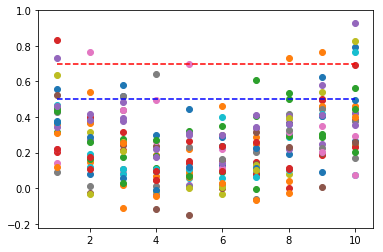

Effective number of parameteres:  60.5461541231
PSIS-LOO:  -31.8067919986


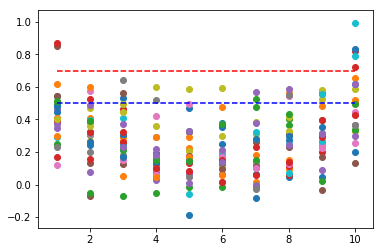

Effective number of parameteres:  54.8379185124
PSIS-LOO:  -31.5138988719


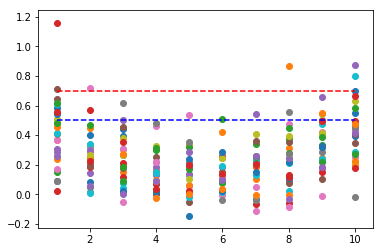

In [9]:
for samples in sep_models_samples:
    S = samples[0]["log_lik"].shape[0]

    log_lik_sep = samples[0]["log_lik"].T
    for sample in samples[1:]:
        log_lik = sample["log_lik"].T
        log_lik_sep = np.concatenate((log_lik_sep,log_lik))
    log_lik_sep = log_lik_sep.T

    loo_sep ,loos_sep, ks_sep = psis.psisloo(log_lik_sep)
    lppd_sep = np.sum(np.log(np.mean(np.exp(log_lik_sep), axis = 0)))
    p_eff_sep = lppd_sep - loo_sep
    print("Effective number of parameteres: ", p_eff_sep)
    print("PSIS-LOO: ", loo_sep)

    K_plot = 25
    ks_sep_matrix = ks_sep.reshape((K_plot,10))
    '''
    for i, sample in enumerate(samples):
        log_lik_i = sample["log_lik"]
        loo_sep_i ,loos_sep_i, ks_sep_i = psis.psisloo(log_lik_i)
        lppd_sep_i = np.sum(np.log(np.mean(np.exp(log_lik_i), axis = 0)))
        p_eff_sep_i = lppd_sep_i - loo_sep_i
        print("-------------------------------------")
        print("Group ", i)
        print("K values > 0.7: {}".format(np.sum(ks_sep_i>=0.7)))
        print("K values > 0.5: {}".format(np.sum(ks_sep_i>0.5)))
        #print("Agg K values > 0.7: {}".format(np.sum(ks_sep_matrix[i]>=0.7)))
        #print("Agg K values > 0.5: {}".format(np.sum(ks_sep_matrix[i]>0.5)))
        print("p_eff for group ", i, ": ", p_eff_sep_i)
        print("p_eff avg: ", p_eff_sep/25)
    '''

    for i in range(K_plot):
        plt.scatter(range(1,11), ks_sep_matrix[i])
    plt.plot(range(1,11), [0.5 for i in range(1,11)], "b--")
    plt.plot(range(1,11), [0.7 for i in range(1,11)], "r--")
    plt.show()


Accordingly, each of the models had most of the k values that assumes appropriate values (less than 0.7) when run on most of the groups, but there are always some of them in which we have k values over 0.5 and even 0.7 and so the $p_{eff}$ values are not reliable because they are likely to be biased, especially because we have even values over 1. For this reason we cannot make any comparison among the different separate models using the PSIS-LOO values and the estimated number of parameters.

### Hierarchical Model

Effective number of parameteres:  43.716101078
PSIS-LOO:  -58.0347938617


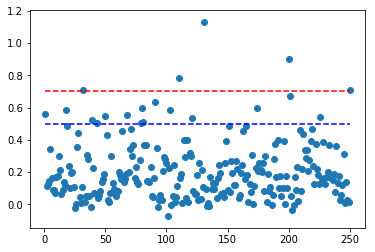

Effective number of parameteres:  44.5170127277
PSIS-LOO:  -58.6078537025


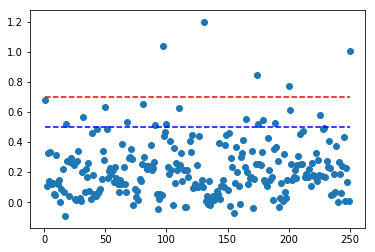

In [10]:
for samples in hier_models_samples:
    log_lik_hier = samples["log_lik"]

    loo_hier ,loos_hier, ks_hier = psis.psisloo(log_lik_hier)
    lppd_hier = np.sum(np.log(np.mean(np.exp(log_lik_hier), axis = 0)))
    p_eff_hier = lppd_hier - loo_hier
    print("Effective number of parameteres: ", p_eff_hier)
    print("PSIS-LOO: ", loo_hier)

    plt.scatter(range(1,251), ks_hier)
    plt.plot(range(1,251), [0.5 for i in range(1,251)], "b--")
    plt.plot(range(1,251), [0.7 for i in range(1,251)], "r--")
    plt.show()

Again, each of the models had most of the k values that assumes appropriate values (less than 0.7), but there are still some of them over 0.5 and even 0.7 and so the $p_{eff}$ values are not reliable because they are likely to be biased, especially because we have even values over 1. For this reason we cannot make any comparison among the different hierarchical models using the PSIS-LOO values and the estimated number of parameters.

## Model Comparison

Our idea was to use the PSIS-LOO values for comparing separate and hierarchical models. However, due to the unreliability of the PSIS-LOO values obtained for all the models, we cannot use these values as valid metric for comparing them. Since the difference between the avereage PSIS-LOO values obtained for the separate models and the one for the hierarchical models is very high, we can only say that is likely that a separate model is better than a hierarchical model because we have higher PSIS-LOO values for the separate models.
In conclusion, to further assess which is the better model it would be required to use a k-fold cross-validation.

## Model visualization

In the following section we are going to provide plots about how the obtained models fitted the data. For both the separate and hierarchical models we are going to provide only the plots for one separate and one hierarchical model. This because for a visual analysis of these plots they can be used interchangeably, and the conclusions that we reached are the same for all of them.

### Separate model
The follwing is the plot for the third separate model. That is the one for which we chose as prior distribution $\alpha \sim \mathcal{N}(\mathbb{E}(y), 100)$, $\beta \sim \mathcal{t}(3, 0, 10)$, Uniform on $\sigma$

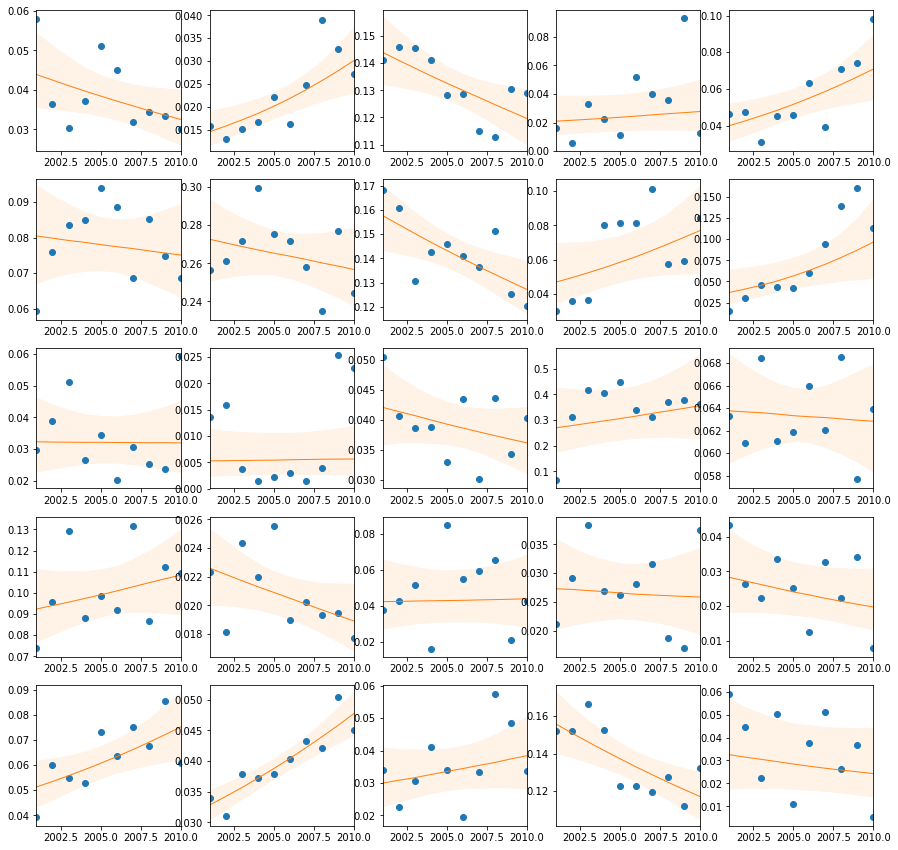

In [33]:
color_scatter = 'C0'  # 'C0' for default color #0
color_line = 'C1'     # 'C1' for default color #1
#for model in sep_models_samples:
model = sep_models_samples[2]
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i, samples in enumerate(model):
    ax = axes[int(i/5), i%5]
    #ax.hist(np.exp(samples['ypred']), 50)
    #ax.set_xlabel('y-prediction for x={}'.format(2011))        

    color_shade = (
        1 - 0.1*(1 - np.array(mpl.colors.to_rgb(color_line)))
    )

    expmu = np.exp(samples['mu'])*100

    ax.fill_between(
        range(2001,2011),
        np.percentile(expmu, 5, axis=0),
        np.percentile(expmu, 95, axis=0),
        color=color_shade
    )

    ax.plot(
        range(2001,2011),
        np.percentile(expmu, 50, axis=0),
        color=color_line,
        linewidth=1
    )

    ax.scatter(range(2001,2011), data[i]*100) #5, color=color_scatter)
    ax.set_xlim((2001, 2010))

    #ax.tight_layout()
plt.show()

### Hierarchical model
The following is the plot for the hierarchical model with weakly informative hyperprior parameters. (See the models descriptions for all the details) 

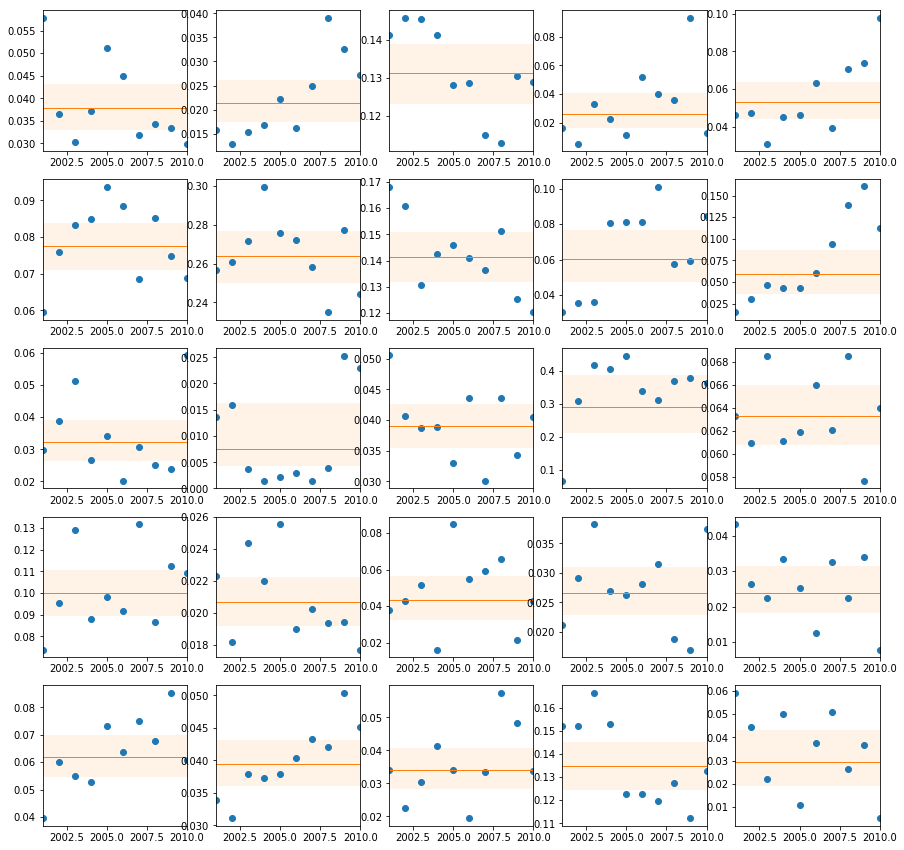

In [34]:
color_scatter = 'C0'  # 'C0' for default color #0
color_line = 'C1'     # 'C1' for default color #1
color_shade = (
    1 - 0.1*(1 - np.array(mpl.colors.to_rgb(color_line)))
)
#for samples in hier_models_samples:
samples = hier_models_samples[1]    
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i in range(samples['ypred'].shape[1]):
    ax = axes[int(i/5), i%5]
    #ax.hist(np.exp(samples['ypred']), 50)
    #ax.set_xlabel('y-prediction for x={}'.format(2011))        
    #print(samples['mu'][:, 10*i:10*(i+1)])
    

    expmu = np.exp(samples['mu'][:, 10*i:10*(i+1)])*100

    ax.fill_between(
        range(2001,2011),
        np.percentile(expmu, 5, axis=0),
        np.percentile(expmu, 95, axis=0),
        color=color_shade
    )

    ax.plot(
        range(2001,2011),
        np.percentile(expmu, 50, axis=0),
        color=color_line,
        linewidth=1
    )

    ax.scatter(range(2001,2011), data[i]*100) #5, color=color_scatter)
    ax.set_xlim((2001, 2010))

    #ax.tight_layout()
plt.show()


In general from the plot for the separate models we have that in most of the cases the Gaussian linear regression model is fitting well the data. Anyway, in some other cases there is a clear presence of outliers, but still the model approximation seems resonable and it is also clear that anyway the model is learning the trend of the datapoints in each group.
On the other hand, it is very clear from the plots that the hierarchial model is not learning the model of the data, therefore in the following analysis we are going to only further assess which among the three separate models is the best to use in practice. In other words, from the analysis done up to know we have enough results to say that we can discard the hierarchical models.

## Predictive performance assessment
We want now to analyse the performance of the three separate models in order to choose which one we should prefer in practice. In order to do that we are going to fit agian the three model but on a restricted dataset. In particular, the model will be fitted on the first 9 years of data, in this way we can then compare the predictions for the 10th year with the actual data points from the dataset. As already said in the previous section we are going to assess only the preformance for the separate models.

In [38]:
N = 9
x = range(2001, 2010)
xpred=2010
K = 25
sep_models_samples_test = []
for sm in sep_stan_models:
    samples = []
    for i in range(K):
        y = np.log(data[i, :-1]).ravel()   # observations
        separate_model_data = dict(
            N = N,
            #K = K,  # 25 contries
            x = x,  # group indicators
            y = y,  # observations
            ymean = y.mean(),
            xpred=xpred
        )

        samples.append(sm.sampling(n_jobs=4, data=separate_model_data))#, control=dict(adapt_delta=0.95, max_treedepth=20)))

        #print('Completed: group ', i)
    print('Completed: separate model')
    sep_models_samples_test.append(samples)    

Completed: separate model
Completed: separate model
Completed: separate model


The following is the plot of the posterior predictive distribution for each group for the third of the three separate models. We are going to plot only the one of the third model for illustration purpose. What we are actually interested in is the mean error on the predictions, so that we can actually compare the three models.

In the following plots the red dotted lines represent the mean of the predictive posterior distribution and the yellow dotted lines are the actual datapoints for the year 2010.

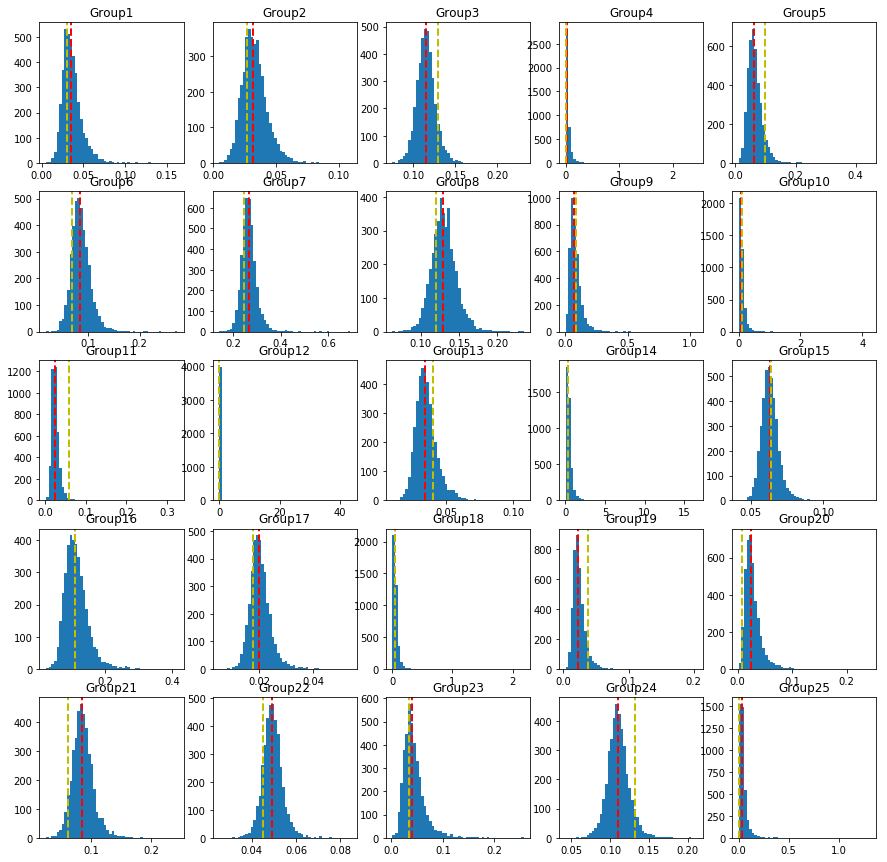

In [43]:
model = sep_models_samples_test[2]
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

for i, group in enumerate(model):   
    ax = axes[int(i/5), i%5]
    ax.hist(np.exp(group['ypred'])*100, 50)
    ax.axvline(np.exp(group['ypred'].mean())*100, color='r', linestyle='dashed', linewidth=2)
    ax.axvline(data[i, -1]*100, color='y', linestyle='dashed', linewidth=2)
    ax.set_title('Group' + str(i+1))# + ': The predictive distribution for year 2010')
plt.show()    

The following is the plot of the Mean Squared Error between the mean values of the predicting distribution given by the models and the actual data points for the year 2010.

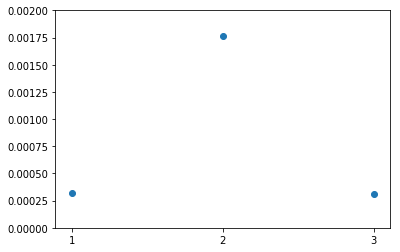

In [28]:
model_MSE = []
for model in sep_models_samples_test:
    errors = []
    for i, group in enumerate(model):   
        error = ((np.exp(group['ypred'].mean()) - data[i, -1])*100)**2
        errors.append(error)
        
    model_MSE.append(np.mean(errors))

plt.scatter(["1","2","3"], model_MSE)
plt.ylim([0,0.002])
plt.show()

Based on the values obtained as MSE for the three models we can say that the first and the third models are on average more accurate than the second one. Therefore, as rule of thumb one should choose the simpler model between the first (the one with uniform priors on $\alpha$, $\beta$, $\sigma$) and the third (the one with gaussian, student t and uniform priors: $\alpha \sim \mathcal{N}(\mathbb{E}(y), 100)$, $\beta \sim \mathcal{t}(3, 0, 10)$, Uniform on $\sigma$). As a result, one should choose the first one as it is the simplest one.

## Final discussion
As mentioned above, due to the problems that we encoutered with the PSIS-LOO values, we couldn't directly assess the performance of the different models, so we had to resort to other methods. In order to further assess which is the best model among the ones that we proposed we should do a K-fold cross validation. It can be a good tradeoff between computationally cost and accuracy, whereas a full LOO-CV would have been too expensive.
Another method that can be used to assess which model is the best could be using the Mean Squared Error among the mean of the predictive distribution for every year and the actual datapoints, to have a global measurement of the quality of the model.

## Appendix A

### Separate model Stan code

In [ ]:
sep_models = ["separ_non_unif_prior.stan", "separ_unif_prior.stan", "separ_non_unif_prior_stud.stan"]
for model in sep_models:
    

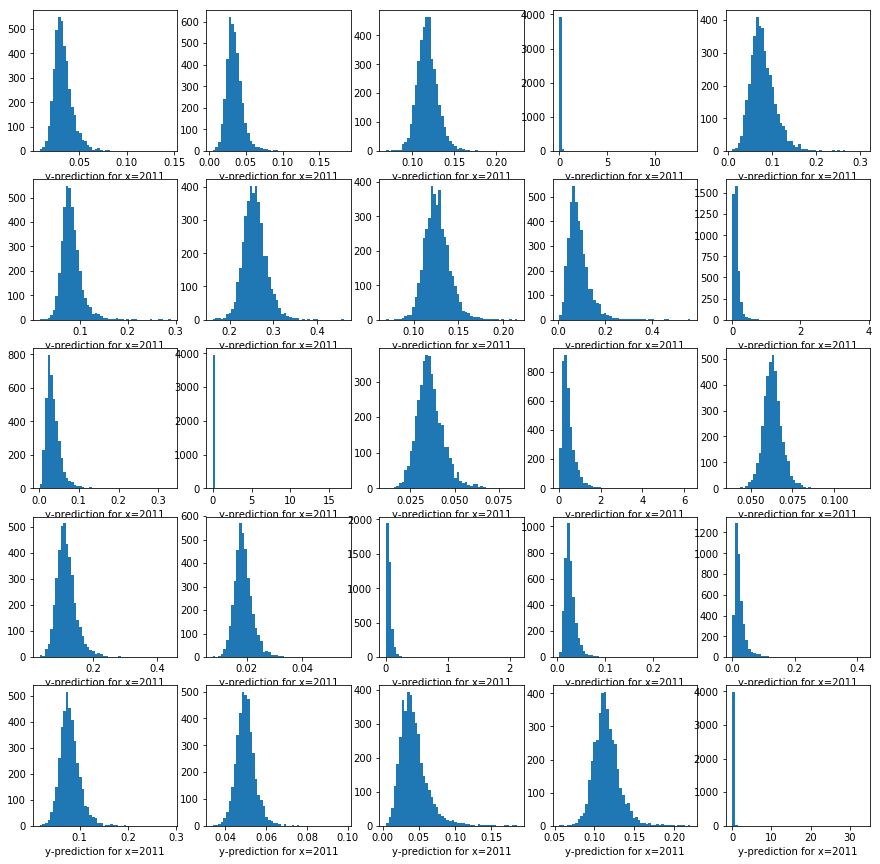

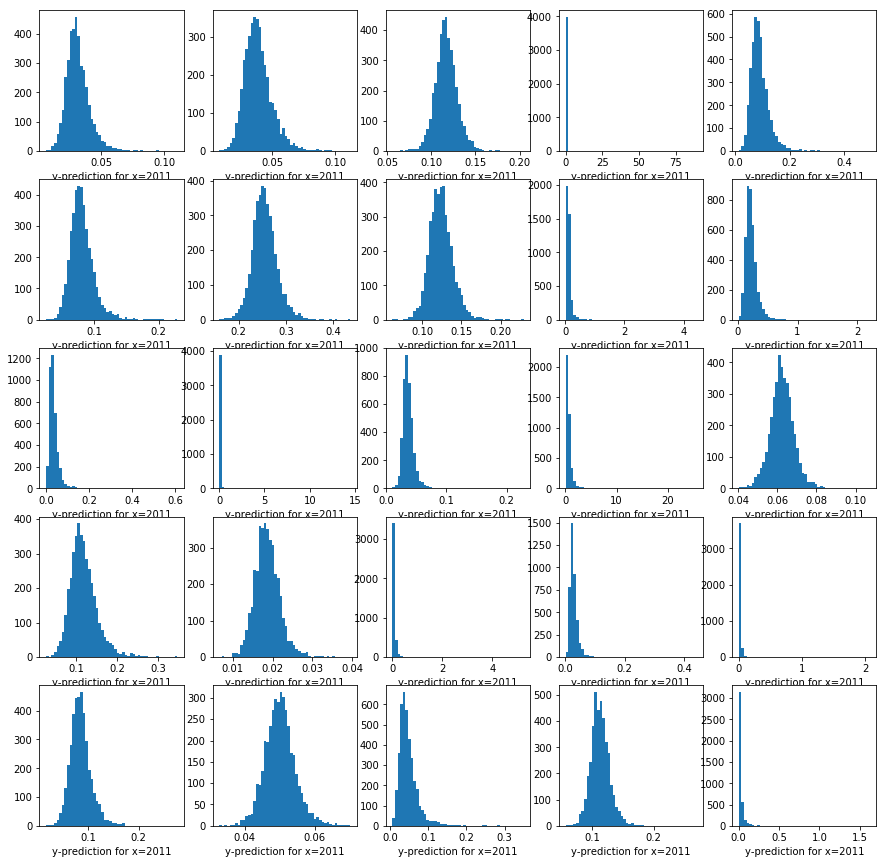

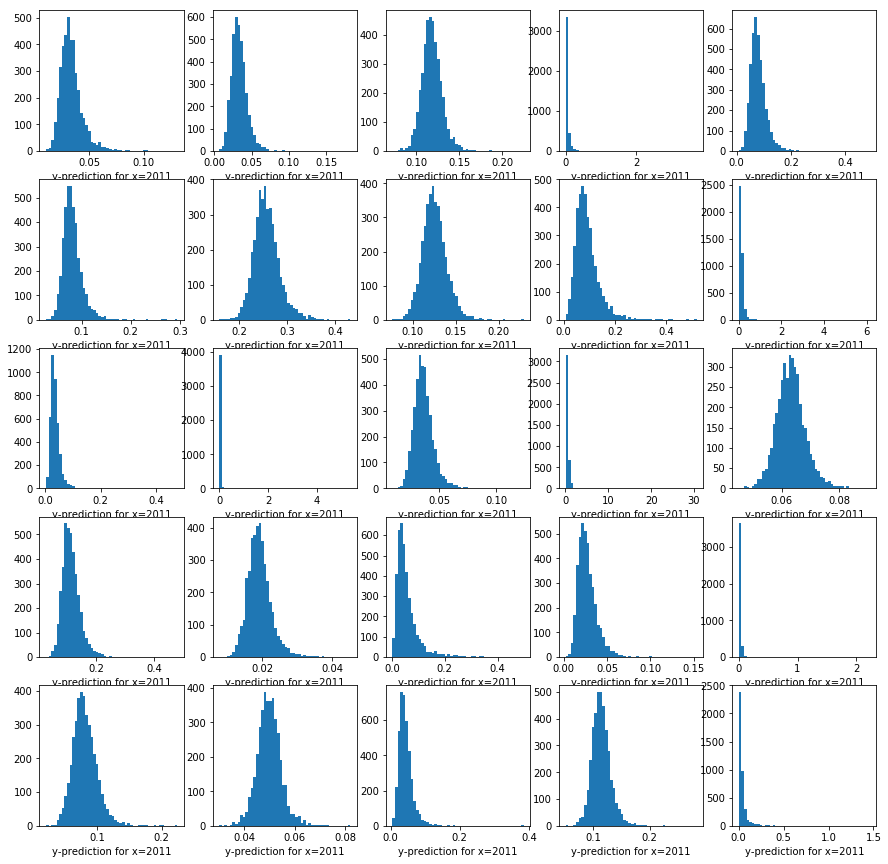

In [11]:
for model in sep_models_samples:
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    for i, samples in enumerate(model):
        ax = axes[int(i/5), i%5]
        ax.hist(np.exp(samples['ypred'])*100, 50)
        ax.set_xlabel('y-prediction for x={}'.format(2011))
        
    plt.show()

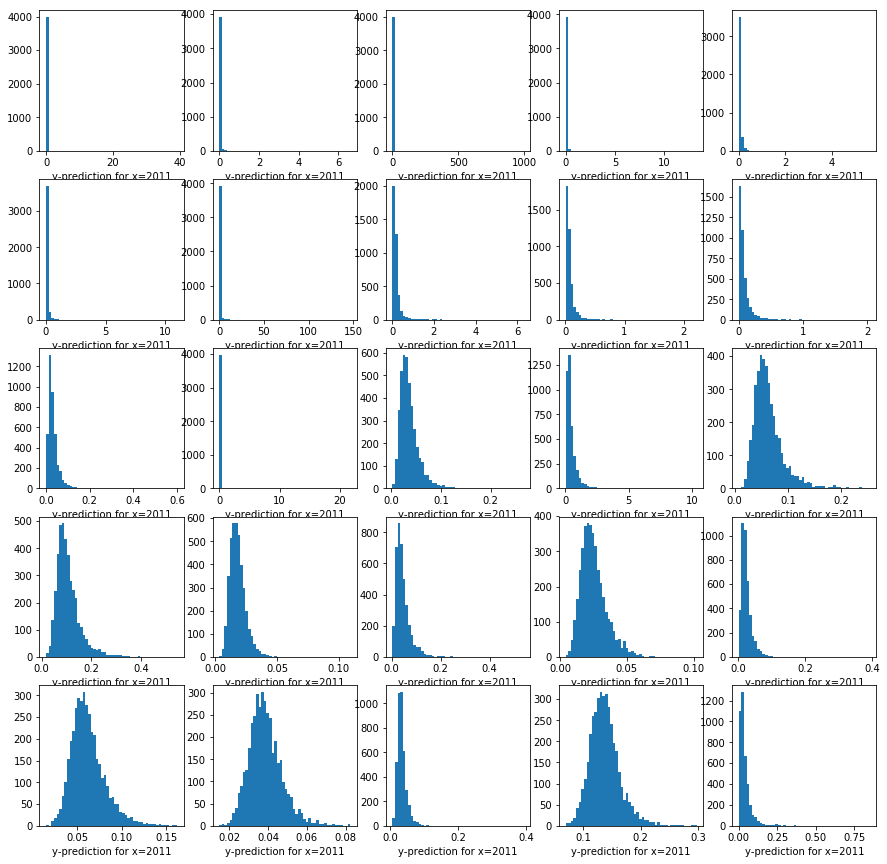

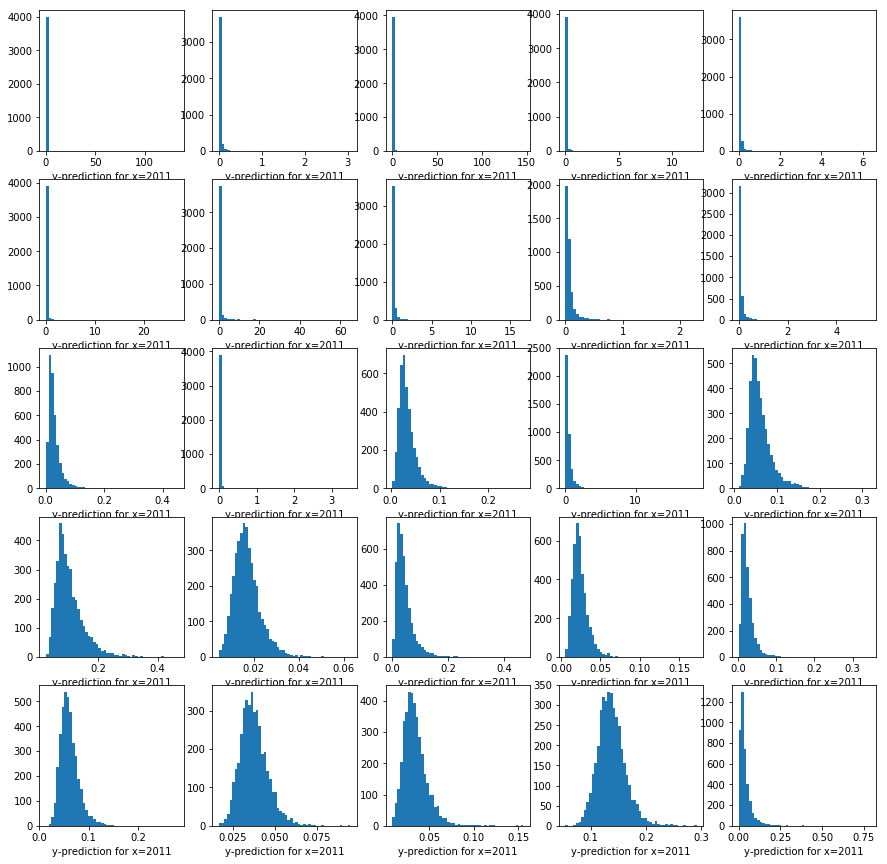

In [13]:
for samples in hier_models_samples:
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    for i in range(samples['ypred'].shape[1]):
        ax = axes[int(i/5), i%5]
        ax.hist(np.exp(samples['ypred'][:, i])*100, 50)
        ax.set_xlabel('y-prediction for x={}'.format(2011))
        
    plt.show()